In [1]:
import valjax as vj

In [2]:
import jax
import jax.numpy as np
from jax import lax

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../config/clean.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
N = 200 # number of grid points
f_lo, f_hi = 0.5, 2.0 # proportional grid range

In [5]:
par0 = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

In [36]:
# find steady state
def get_kss(par):
    β, δ, α, z = par['β'], par['δ'], par['α'], par['z']
    return (α*z/((1-β)/β+δ))**(1/(1-α))
k_ss = get_kss(par0)

In [7]:
# construct capital grid
k_min, k_max = f_lo*k_ss, f_hi*k_ss
k_grid = np.linspace(k_min, k_max, N)

In [8]:
def util(c, ϵ=1e-6):
    u0 = np.log(ϵ) + (c/ϵ-1)
    u1 = np.log(np.maximum(ϵ, c))
    return np.where(c >= ϵ, u1, u0)

In [9]:
def prod(z, k, α):
    return z*k**α

In [10]:
def value(par, grid, st, tv):
    β = par['β']
    cp = grid['cp']
    vn = st['vn']
    t = tv['t']

    vp = util(cp) + β*vn[None,:]
    ip = vj.smoothmax(vp, axis=1)
    kp = vj.interp_index(k_grid, ip)
    v = vj.interp_address(vp, ip, axis=1)
    
    stp = {
        'vn': v,
    }
    
    out = {
        'v': v,
        'kp': kp,
    }
    
    return stp, out

In [11]:
def solve(par, T):
    α = par['α']
    δ = par['δ']
    z = par['z']

    y_grid = prod(z, k_grid, α)
    yd_grid = y_grid + (1-δ)*k_grid
    cp_grid = yd_grid[:,None] - k_grid[None,:]

    grid = {
        'cp': cp_grid
    }
    value1 = jax.partial(value, par, grid)

    st0 = {
        'vn': util(y_grid),
    }
    tv = {
        't': np.arange(T)[::-1],
    }
    last, path = lax.scan(value1, st0, tv)

    return path

In [12]:
jsolve = jax.jit(solve, static_argnums=(1,))

In [23]:
ret = jsolve(par0, 100)

In [24]:
%timeit -r 10 -n 10 jsolve(par0, 30)

717 µs ± 25 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


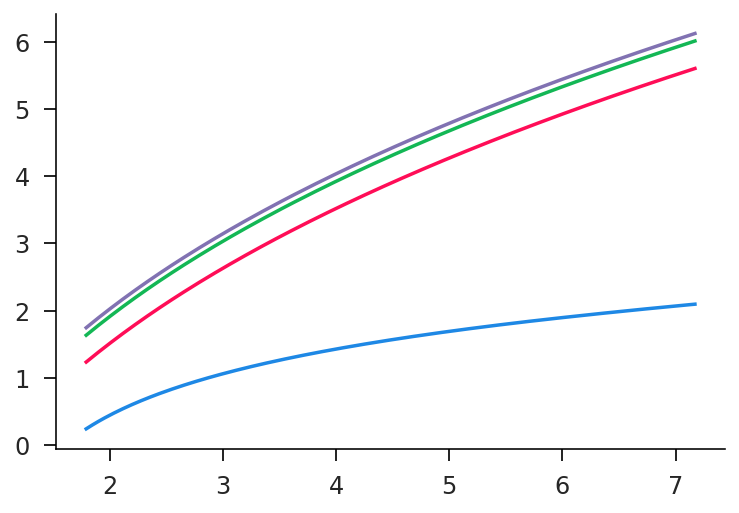

In [30]:
plt.plot(k_grid, ret['v'][::25,:].T);

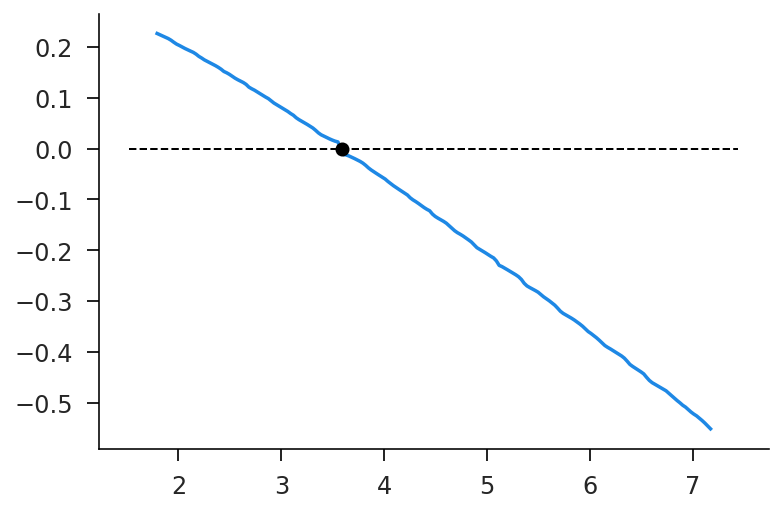

In [31]:
fig, ax = plt.subplots()
ax.plot(k_grid, ret['kp'][-1,:]-k_grid);
ax.hlines(0, *plt.xlim(), linewidth=1, linestyle='--', color='k')
ax.scatter(k_ss, 0, color='k', zorder=10);

In [32]:
def moments(par, T):
    ret = solve(par, T)
    kp = ret['kp']
    i = kp - k_grid
    μi = np.mean(i)
    return μi

In [33]:
g_moments = jax.grad(moments, argnums=(0,))
jg_moments = jax.jit(g_moments, static_argnums=(1,))

In [34]:
jg_moments(par0, 30)

({'z': DeviceArray(0.6969132, dtype=float32),
  'α': DeviceArray(3.0524044, dtype=float32),
  'β': DeviceArray(5.0408044, dtype=float32),
  'δ': DeviceArray(-5.043301, dtype=float32)},)

In [35]:
%timeit -r 10 -n 10 _, = jg_moments(par0, 30);

2.34 ms ± 167 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
